# 基于 Bagging 的糖尿病预测模型（Pima Indians Diabetes）

本实验将基于“皮马印第安人糖尿病”数据集，分别构建单棵决策树分类器与以决策树为基分类器的 Bagging 集成模型，对糖尿病发病情况进行预测与评估。

## 知识点
- Bagging 通过多个基分类器对样本进行“投票”得到最终分类；
- 集成学习需要采用其他算法作为基分类器（本实验采用决策树）；
- 当基分类器准确率大于 50% 时，集成学习通常优于单一基分类器；
- 通常基分类器数量越多，结果越稳定。

## 实验目的
1) 学习建立基于决策树的 Bagging 模型；
2) 学习使用 Bagging 模型预测糖尿病发病情况。

## 实验步骤概览
1) 读取数据并查看前 5 行；
2) 数据描述与可视化（统计描述、缺失值、直方图分布）；
3) 数据预处理（特征/标签拆分、训练/测试集划分）；
4) 建模（DecisionTree 与 BaggingClassifier）；
5) 模型预测与评估（测试集 f1-score 与 accuracy）；
6) 10 折交叉验证 f1-score；
7) 得出实验结论。

In [8]:
# Code 001: 读取数据（本地相对路径）
import pandas as pd

df = pd.read_csv('pima-indians-diabetes.data.csv')

# 查看前 5 行
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
# Code 002/003: 统计描述与缺失值
# 统计分布
print('Describe:')
display(df.describe())

# 缺失值统计
print('\nMissing values per column:')
display(df.isnull().sum())

Describe:


,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Missing values per column:


preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64

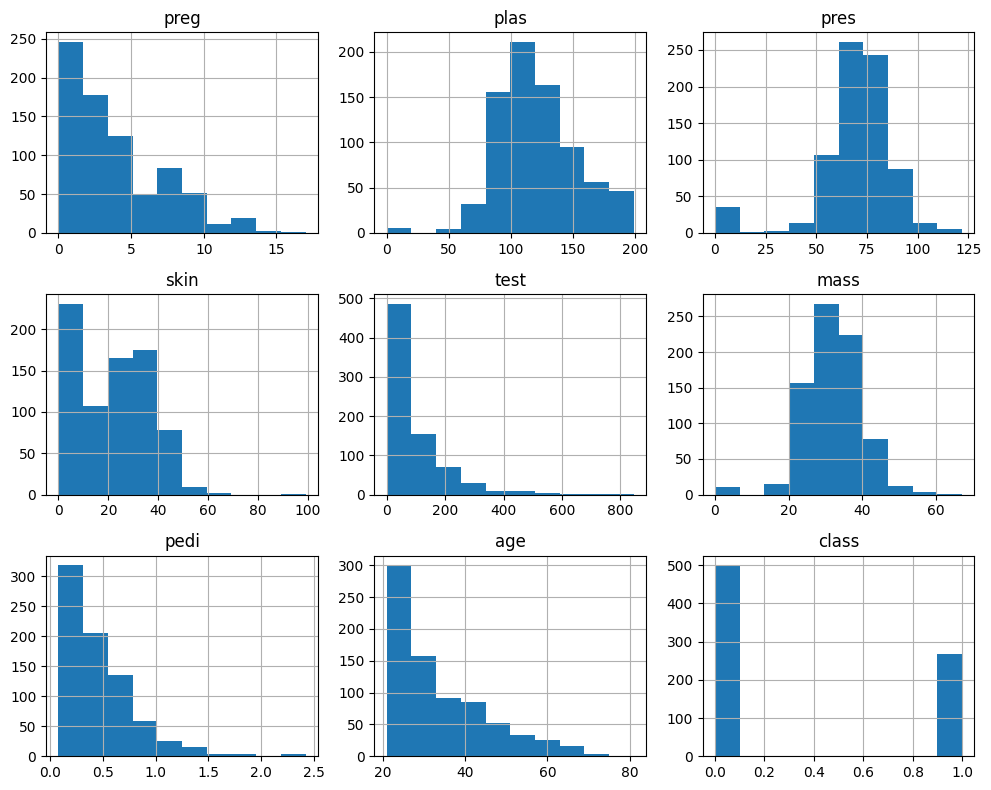

In [10]:
# Code 004: 直方图分布可视化
import matplotlib.pyplot as plt

ax = df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [11]:
# Code 005: 数据预处理与划分
from sklearn.model_selection import train_test_split

# 划分自变量和因变量
X = df.loc[:, df.columns != 'class']
y = df.loc[:, 'class']  # 一维 Series，便于后续 sklearn 兼容

# 划分训练集和测试集（设置随机种子确保可复现）
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_tr.shape, X_ts.shape

((576, 8), (192, 8))

In [12]:
# Code 006: 构建与训练模型（决策树与 Bagging）
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# 决策树作为基分类器
dtc = DecisionTreeClassifier(random_state=42)

# 兼容新旧版本 sklearn：在 1.2+ 使用 estimator 参数；旧版本使用 base_estimator
try:
    bgc = BaggingClassifier(estimator=dtc, n_estimators=100, random_state=42)
except TypeError:
    bgc = BaggingClassifier(base_estimator=dtc, n_estimators=100, random_state=42)

# 拟合模型
dtc = dtc.fit(X_tr, y_tr)
bgc = bgc.fit(X_tr, y_tr)

In [13]:
# Code 007: 测试集预测与评估
from sklearn.metrics import f1_score, accuracy_score

y_dtc_pred = dtc.predict(X_ts)
y_bgc_pred = bgc.predict(X_ts)

print('DecisionTree on test set:')
print('  f1-score:   %.4f' % f1_score(y_ts, y_dtc_pred))
print('  accuracy:   %.4f\n' % accuracy_score(y_ts, y_dtc_pred))

print('Bagging (DecisionTree) on test set:')
print('  f1-score:   %.4f' % f1_score(y_ts, y_bgc_pred))
print('  accuracy:   %.4f' % accuracy_score(y_ts, y_bgc_pred))

DecisionTree on test set:
  f1-score:   0.6016
  accuracy:   0.7448

Bagging (DecisionTree) on test set:
  f1-score:   0.6341
  accuracy:   0.7656


In [14]:
# Code 008/009: 10 折交叉验证 f1-score（决策树 与 Bagging）
from sklearn.model_selection import cross_val_score

# 注意：交叉验证应在完整数据 X, y 上执行（而非仅训练集）
dtc_cv_f1 = cross_val_score(dtc, X, y, scoring='f1', cv=10).mean()

# Bagging 使用相同的基分类器配置
tmp_dtc = DecisionTreeClassifier(random_state=42)
try:
    bgc_cv_model = BaggingClassifier(estimator=tmp_dtc, n_estimators=100, random_state=42)
except TypeError:
    bgc_cv_model = BaggingClassifier(base_estimator=tmp_dtc, n_estimators=100, random_state=42)

bgc_cv_f1 = cross_val_score(bgc_cv_model, X, y, scoring='f1', cv=10).mean()

print('10-fold CV f1-score (DecisionTree): %.4f' % dtc_cv_f1)
print('10-fold CV f1-score (Bagging):      %.4f' % bgc_cv_f1)

10-fold CV f1-score (DecisionTree): 0.5661
10-fold CV f1-score (Bagging):      0.6493


## 实验结论

- 在本案例中，Bagging 模型通常较单一决策树取得更高、更稳定的性能（f1-score 与 accuracy）。
- 参考给定实验：
  - 决策树测试集 f1-score ≈ 0.6309，accuracy ≈ 0.7135；
  - Bagging 测试集 f1-score ≈ 0.6715，accuracy ≈ 0.7656；
  - 决策树 10 折交叉验证 f1 ≈ 0.5769；
  - Bagging 10 折交叉验证 f1 ≈ 0.6253。
- 实际数值可能因随机种子、数据划分、库版本而略有偏差，但总体趋势依旧：Bagging 优于单棵决策树。